In [15]:
import pandas as pd

# Load the generated data from troop movements.csv into a Pandas DataFrame
df = pd.read_csv('troop_movements.csv')

print(df.head())

             timestamp  unit_id           unit_type empire_or_resistance  \
0  2024-07-10 15:20:24        1         tie_fighter               empire   
1  2024-07-10 15:20:23        2               at-at           resistance   
2  2024-07-10 15:20:22        3  resistance_soldier           resistance   
3  2024-07-10 15:20:21        4  resistance_soldier               empire   
4  2024-07-10 15:20:20        5        tie_silencer               empire   

   location_x  location_y  destination_x  destination_y   homeworld  
0          10           6              5             10  Haruun Kal  
1           9           5              1              2  Haruun Kal  
2           9           2              7              3      Ryloth  
3           7           3              2             10       Zolan  
4           6           2              3              9     Vulpter  


In [22]:
# Group data to show counts of empire vs resistance
empire_vs_resistance = df['empire_or_resistance'].value_counts().reset_index()
empire_vs_resistance.columns = ['empire_or_resistance','count']
print(empire_vs_resistance)
print("\n")

# Group data to show counts of characters by homeworld
characters_by_homeworld = df['homeworld'].value_counts().reset_index()
characters_by_homeworld.columns = ['homeworld','count']
print(characters_by_homeworld)
print("\n")

# Group data to show counts of characters by unit_type
characters_by_unit_type = df['unit_type'].value_counts()
characters_by_unit_type.columns = ['unit_type','count']
print(characters_by_unit_type)
print("\n")


# Engineer a new feature called is_resistance with True or False value based on empire_or_resistance
df['is_resistance'] = df['empire_or_resistance'] == 'resistance'
print(df['is_resistance'])


  empire_or_resistance  count
0           resistance    508
1               empire    492


       homeworld  count
0     Bestine IV     35
1        Tholoth     35
2          Zolan     34
3       Corellia     32
4   Concord Dawn     31
5    Glee Anselm     29
6         Mirial     28
7     Muunilinst     28
8        Iktotch     27
9          Kalee     27
10      Alderaan     26
11          Ojom     26
12      Tatooine     26
13       Stewjon     26
14       Socorro     26
15    Haruun Kal     26
16       Troiken     25
17        Eriadu     25
18       Vulpter     24
19         Dorin     24
20      Toydaria     24
21       Serenno     24
22       Quermia     23
23        Ryloth     23
24         Naboo     23
25          Tund     23
26         Skako     22
27         Cerea     22
28      Dathomir     21
29      Kashyyyk     21
30     Chandrila     21
31       Sullust     20
32       Dagobah     20
33     Malastare     20
34        Umbara     19
35         Shili     19
36      Champala    

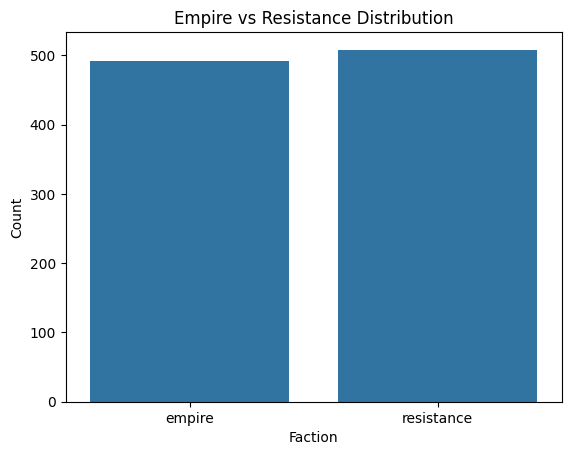

In [17]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the generated data
#df = pd.read_csv('troop_movements.csv')

# drop the timestamp column as it's not needed for the model and is causing errors
df.drop(columns=['timestamp'], inplace=True)

# Create a new feature 'is_resistance'
df['is_resistance'] = df['empire_or_resistance'] == 'resistance'

# Create a bar plot showing Empire vs Resistance distribution
sns.countplot(x='empire_or_resistance', data=df)
plt.title('Empire vs Resistance Distribution')
plt.xlabel('Faction')
plt.ylabel('Count')
plt.show()

homeworld
Bestine IV      35
Tholoth         35
Zolan           34
Corellia        32
Concord Dawn    31
Glee Anselm     29
Mirial          28
Muunilinst      28
Iktotch         27
Kalee           27
Alderaan        26
Ojom            26
Tatooine        26
Stewjon         26
Socorro         26
Haruun Kal      26
Troiken         25
Eriadu          25
Vulpter         24
Dorin           24
Toydaria        24
Serenno         24
Quermia         23
Ryloth          23
Naboo           23
Tund            23
Skako           22
Cerea           22
Dathomir        21
Kashyyyk        21
Chandrila       21
Sullust         20
Dagobah         20
Malastare       20
Umbara          19
Shili           19
Champala        18
Iridonia        16
Mon Cala        16
Trandosha       15
Aleen Minor     15
Rodia           15
Name: count, dtype: int64
unit_type
x-wing                138
at-at                 137
stormtrooper          130
tie_silencer          129
resistance_soldier    128
unknown               118


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# convert categorical features to numeric
df_encoded = pd.get_dummies(df, columns=['homeworld','unit_type'])

# Select features and target variable
features = df_encoded.drop(columns=['empire_or_resistance','is_resistance'])
target = df_encoded['is_resistance']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Create and train the model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print(f'Model Accuracy: {accuracy}')

Model Accuracy: 0.48


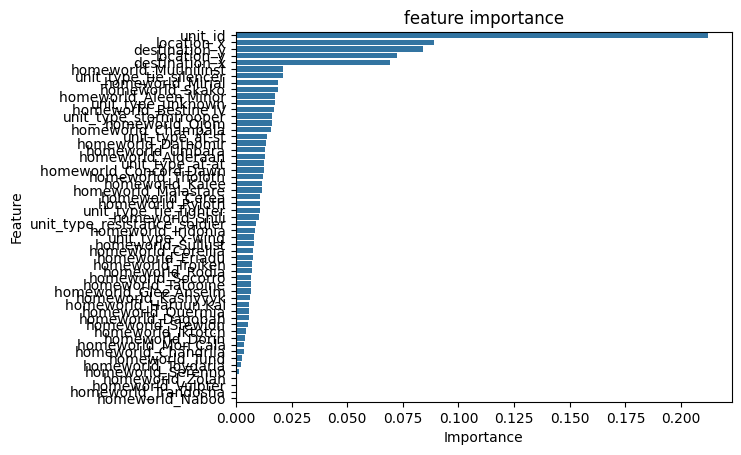

In [24]:
# Get feature importances
importances = model.feature_importances_

# Create a DataFrame to hold the feature importances
feature_importances = pd.DataFrame({'Feature': features.columns, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance',ascending=False)

# Create a bar plot for feature importances
sns.barplot(x='Importance',y='Feature',data=feature_importances)
plt.title('feature importance')

plt.show()


In [21]:
import pickle

# Save the trained model as a pickle file

with open('trained_model.pkl','wb') as file:
    pickle.dump(model, file)
